In [3]:
import pandas as pd
import numpy as np
import missingno as msno

In [2]:
data = pd.read_csv('Dataset/Melbourne_housing_FULL.csv')

<AxesSubplot: >

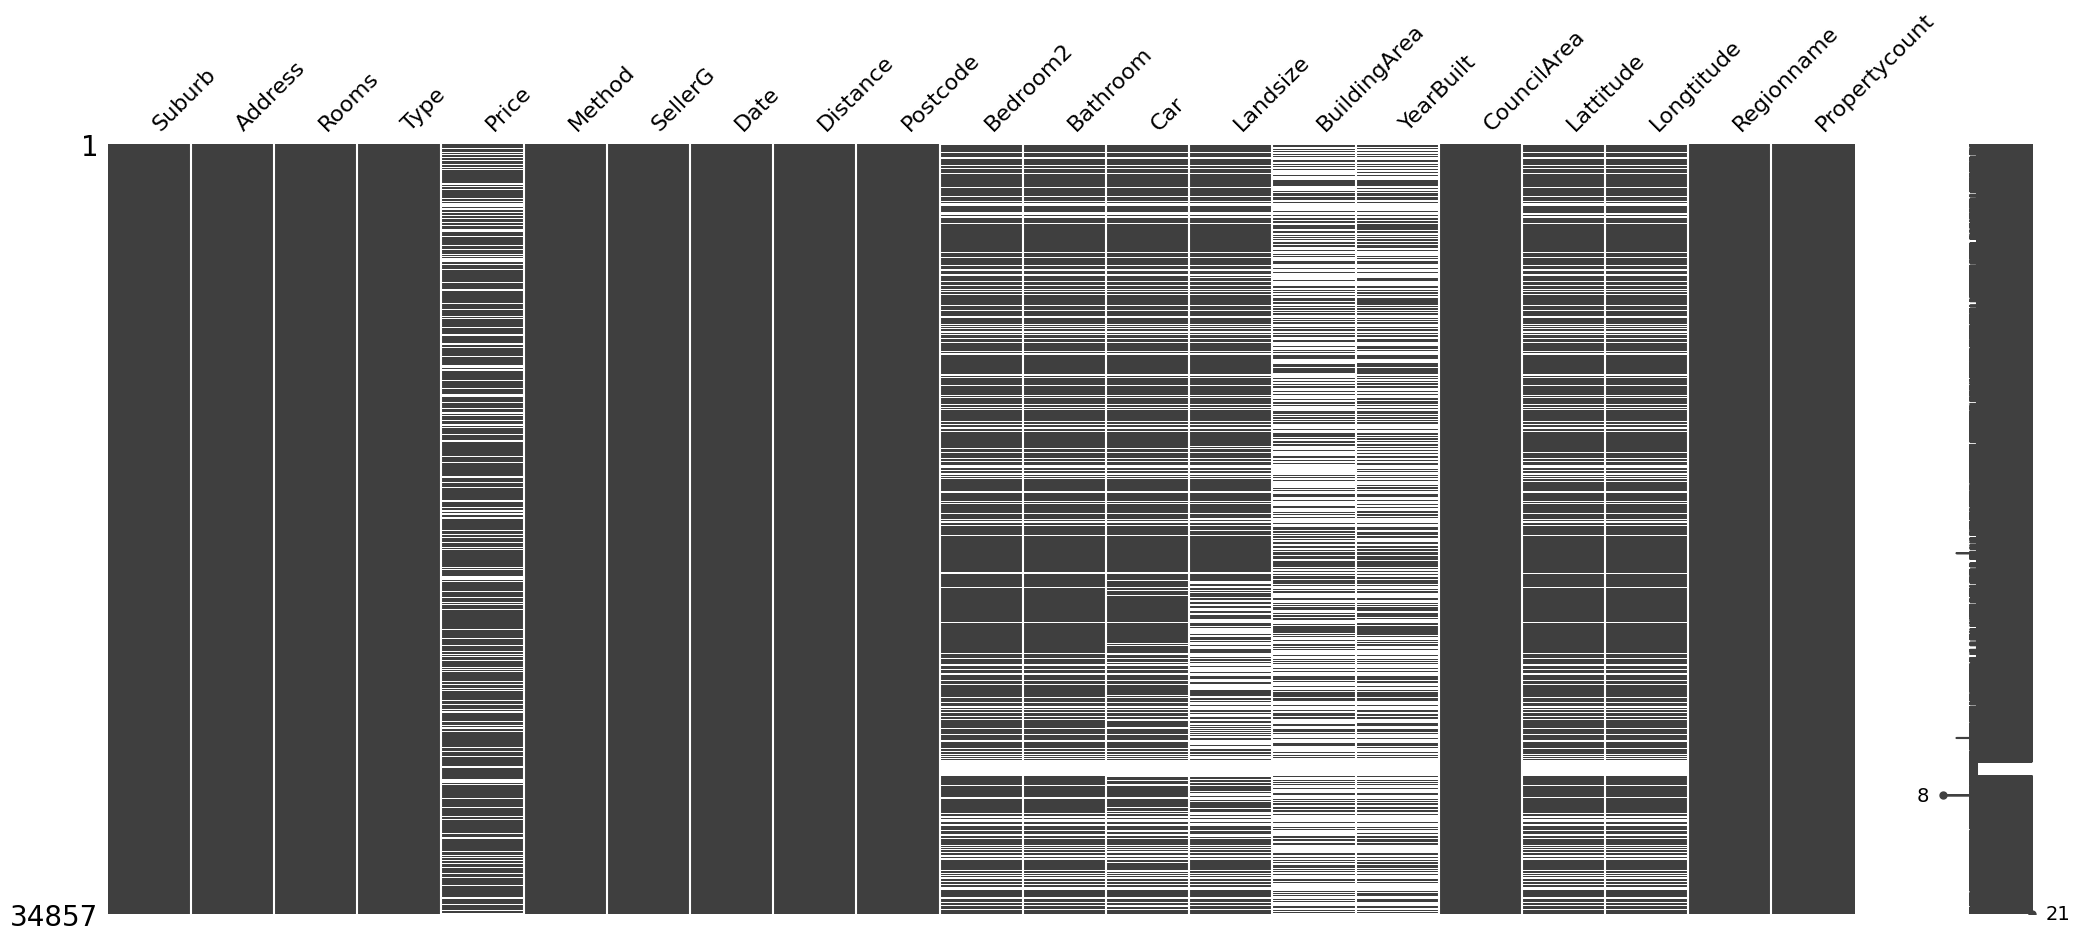

In [4]:
msno.matrix(data)